In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import rasterio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.feature_extraction.image import extract_patches_2d

import cProfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

def cum_sum(arr, s):
    cumsum = torch.cumsum(torch.cumsum(arr,dim=2),dim=3)
    cumsum = F.pad(cumsum,(1,0,1,0),'constant',0)
    tot = cumsum[:,:,:-s,:-s]-cumsum[:,:,s:,:-s]-cumsum[:,:,:-s,s:]+cumsum[:,:,s:,s:]
    return tot

def to_disp(arr):
    arr_c = arr.cpu().numpy()
    arr_c = np.rollaxis(np.squeeze(arr_c),0,3)
    return arr_c

#learns N x N epitome from T, K x K random patches drawn from input image x.
#Applies NIT iterations of the E-M algorithm at scales sc; T*sc^2 patches are sampled.
#e,ev = initial epitome mean and variance. The mean is initialized
#to the uniform image with some small noise, and the variance is initialized to 1
#p holds an array of probabilities of using each part of the epitome

def epitome(x,K,N,T,NIT,sc):
    xFIN = x
    x = F.interpolate(x,scale_factor=sc[0])
    #x = torch.clamp(F.interpolate(x,scale_factor=sc[0]),min=0,max=1)
    _, numDim, SY, SX = x.shape
    TFIN = T
    T = int(np.ceil(T*sc[0]**2))
    NFIN = N
    N = int(np.ceil(sc[0]*N))
    #e = mean of image plus noise
    e = torch.zeros((1,numDim,N,N)).to(device)
    ev = torch.ones((1,numDim,N,N)).to(device)/50
    for i in range(numDim):
        e[:,i,:,:] = x[0,i,:,:].std()*torch.randn(N,N).to(device)/100+x[0,i,:,:].mean()
    p = torch.ones((N,N)).to(device)/N**2
    MINP = 1e-8#1e-8 is acceptable
    MINV = 1e-2#1e-6
    #allocate trace of epitome
    etr = torch.zeros((NIT+1,1,numDim,NFIN,NFIN))
    etr[0,:,:,:,:] = F.interpolate(e,[NFIN,NFIN])
    #perform NIT iterations of EM algorithm
    for sci in range(len(sc)):
        if sci != 0:
            N = int(np.ceil(sc[sci]*NFIN))
            e = F.interpolate(e,[N,N]).to(device)
            #e = torch.clamp(F.interpolate(e,[N,N]),min=0,max=1).to(device)
            ev = F.interpolate(ev,[N,N]).to(device)
            #ev = torch.clamp(F.interpolate(ev,[N,N]),min=MINV).to(device)
            p = torch.ones((N,N)).to(device)/N**2
            x = F.interpolate(xFIN,scale_factor=sc[sci]).to(device)
            #x = torch.clamp(F.interpolate(xFIN,scale_factor=sc[sci]),min=0,max=1).to(device)
            T = int(np.ceil(sc[sci]**2*TFIN))
        sumP = torch.zeros((N,N),dtype=torch.float).to(device)
        sumPy = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        sumPy2 = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        ewrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        evwrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        SY = x.shape[2]
        SX = x.shape[3]
        patchnum = min(T,(SY-K)**2)
        ytemp = np.rollaxis(extract_patches_2d(torch.squeeze(x).permute(1,2,0),(K,K),max_patches=patchnum),3,1)
        y = torch.from_numpy(ytemp).float().to(device)
        for nit in range(NIT):
            #glues together borders of e
            ewrap[:,:N,:N] = e;
            ewrap[:,N:,:] = ewrap[:,:K-1,:]
            ewrap[:,:,N:] = ewrap[:,:,:K-1]
            evwrap[:,:N,:N] = ev
            evwrap[:,N:,:] = evwrap[:,:K-1,:]
            evwrap[:,:,N:] = evwrap[:,:,:K-1]
            evwrapi = 1./evwrap
            # E STEP
            sumP[:,:] = 0
            sumPy[:,:,:] = 0
            sumPy2[:,:,:] = 0
            yt = torch.flip(y,[2,3])
            tmp3 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2*evwrapi,0),K)),dim=0)
            tmp4 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(torch.log(evwrap),0),K)),dim=0)
            idxp = 0
            batch_size = 2000
            while idxp*batch_size<patchnum:
                ytc = yt[idxp*batch_size:idxp*batch_size+batch_size,:,:,:]
                tmp1full = torch.squeeze(F.conv2d(torch.unsqueeze(evwrapi,0),ytc**2))
                tmp2full = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap*evwrapi,0),ytc))
                for tx in range(tmp1full.shape[0]):
                    t = batch_size*idxp+tx
                    tmp1 = tmp1full[tx,:,:]
                    tmp2 = tmp2full[tx,:,:]
                    lP = torch.log(p)-.5*(tmp4+tmp1-2*tmp2+tmp3)
                    P = torch.exp(lP-torch.max(lP))+MINP
                    P /= torch.sum(P)
                    tmp = F.pad(P.view(1,1,N,N),(K-1,K-1,K-1,K-1),'constant',0).to(device)
                    tmp_sumP = torch.squeeze(cum_sum(tmp,K))
                    tmp_sumP[:,:K-1] += tmp_sumP[:,N:]
                    tmp_sumP[:K-1,:] += tmp_sumP[N:,:]
                    sumP += tmp_sumP[:N,:N]
                    yctmp = torch.unsqueeze(y[t,:,:,:],1)
                    tmp_sumPy = torch.squeeze(F.conv2d(tmp,yctmp))
                    tmp_sumPy[:,:,:K-1] += tmp_sumPy[:,:,N:]
                    tmp_sumPy[:,:K-1,:] += tmp_sumPy[:,N:,:]
                    sumPy += tmp_sumPy[:,:N,:N]
                    tmp_sumPy2 = torch.squeeze(F.conv2d(tmp,yctmp**2))
                    tmp_sumPy2[:,:,:K-1] += tmp_sumPy2[:,:,N:]
                    tmp_sumPy2[:,:K-1,:] += tmp_sumPy2[:,N:,:]
                    sumPy2 += tmp_sumPy2[:,:N,:N]
                torch.cuda.empty_cache()
                idxp += 1
            #del tmp1full, tmp2full,tmp,tmp_sumPy,tmp_sumPy2
            torch.cuda.empty_cache()
            #M STEP
            #p = sumP/torch.sum(sumP)#commented out
            e[0,:,:,:] = sumPy/sumP
            if nit>10 or sci>0:
                ev[0,:,:,:] = sumPy2/sumP - 2*e[0,:,:,:]*sumPy/sumP+e[0,:,:,:]**2
            ev = torch.clamp(ev,min=MINV)
            etemp = F.interpolate(e,[NFIN,NFIN])
            etr[nit+1,:,:,:] = etemp
            fig=plt.figure(figsize=(15,5))
            fig.add_subplot(131)
            plt.axis('off')
            td = to_disp(etemp[:,:3,:,:])
            plt.imshow(td)
            plt.title(str(N)+'x'+str(N)+' epitome')
            e_colors = e[0,4:,:,:].permute(1,2,0).view(-1,6)
            labeled = np.reshape(torch.mm(e_colors,palette_torch).cpu().numpy()/256,(N,N,3))
            fig.add_subplot(132)
            plt.axis('off')
            plt.imshow(labeled)
            #plt.imshow(p,cmap='hot',interpolation='nearest')
            plt.title('labeled epitome')
            fig.add_subplot(133)
            plt.axis('off')
            curr_heat = np.sum(np.squeeze(ev.cpu().numpy()),axis=0)
            plt.imshow(curr_heat,cmap='hot',interpolation='nearest')
            plt.title('variances')
            plt.show()
            plt.close()   
        torch.cuda.empty_cache()
    return e,ev,p,etr

[ 2  3  4  5  6 15]


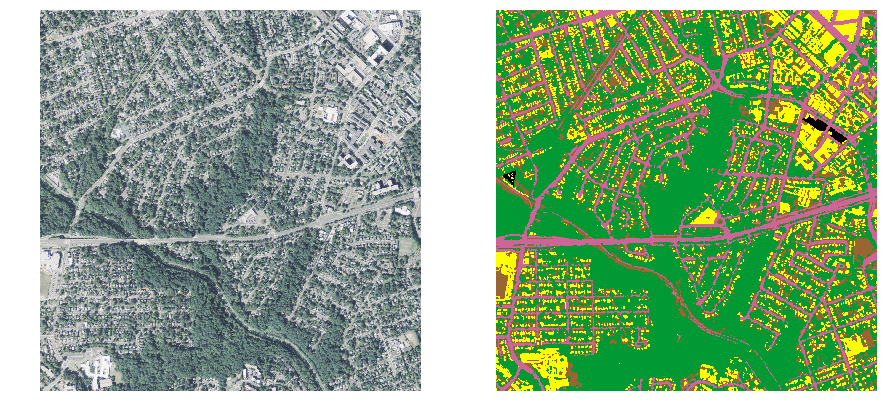

CPU times: user 3.47 s, sys: 864 ms, total: 4.33 s
Wall time: 5.67 s


In [40]:
%%time
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])
palette_torch = torch.from_numpy(palette[1:,:]).float().to(device)

tile = 0
cut = 2048
naip_tile = rasterio.open("/mnt/blobfuse/esri-naip/"+paths[tile][:-7]+".mrf",'r')
naip = naip_tile.read().astype(float)[:,:cut,:cut]/255.
naip_tile.close()

lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[tile],'r')
lc = np.squeeze(lc_tile.read())[:cut,:cut]
lc_tile.close()
print(np.unique(lc))
lc[lc==1]=10
lc[lc==2]=1
lc[lc==10]=2
lc[lc==4]=0
lc[lc==15]=4
fig=plt.figure(figsize=(15,10))
fig.add_subplot(121)
plt.axis('off')
plt.imshow(np.rollaxis(naip,0,3)[:,:,:3])
fig.add_subplot(122)
plt.axis('off')
plt.imshow(palette[lc])
plt.show()
plt.close()

trIM = np.zeros((10,naip.shape[1],naip.shape[2]),dtype=float)
trIM[:4,:,:] = naip
for i in range(6):
    trIM[4+i,:,:] = (lc==(i+1))
trIM = np.expand_dims(trIM,axis=0)
trIMtorch = torch.from_numpy(trIM).float().to(device)
tsIMtorch = trIMtorch

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


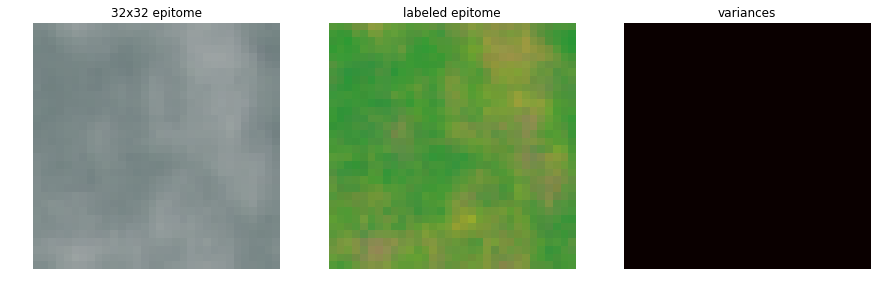

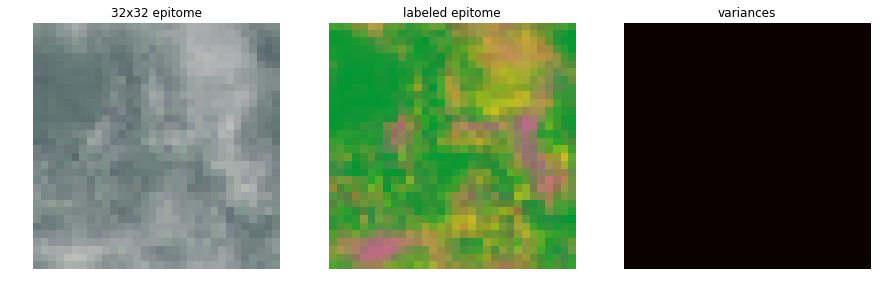

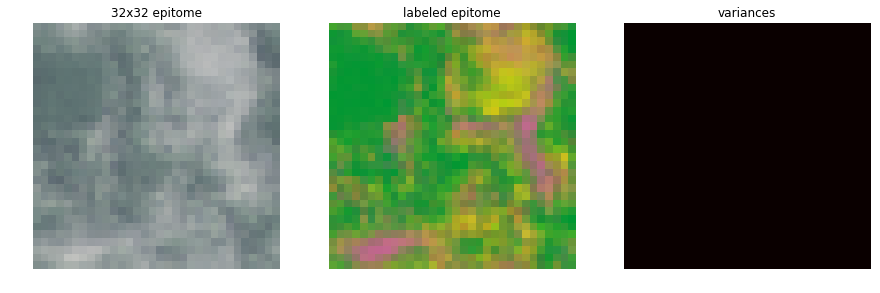

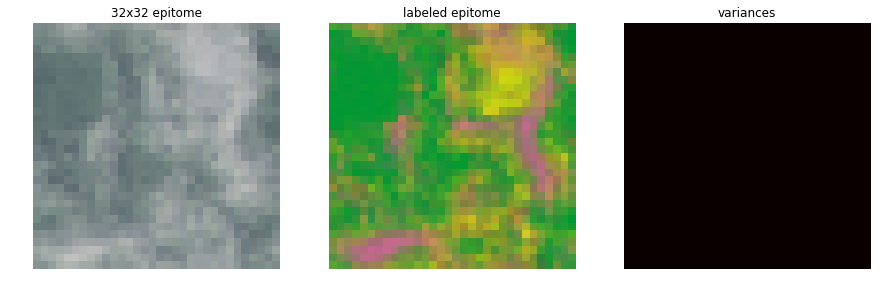

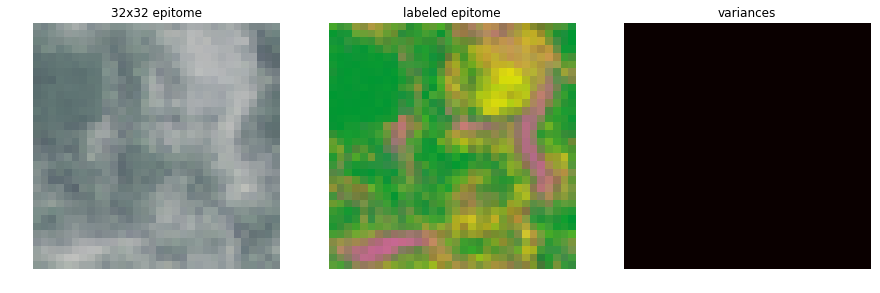

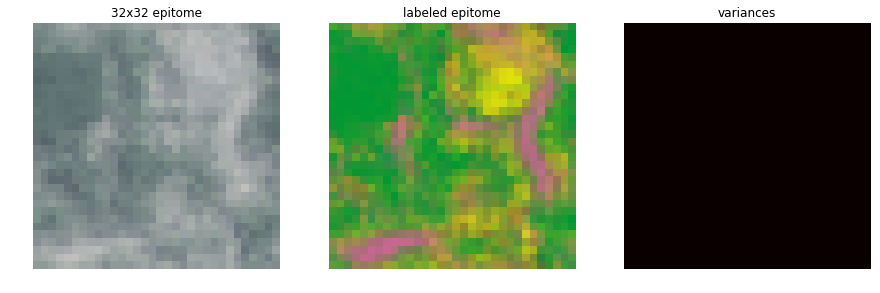

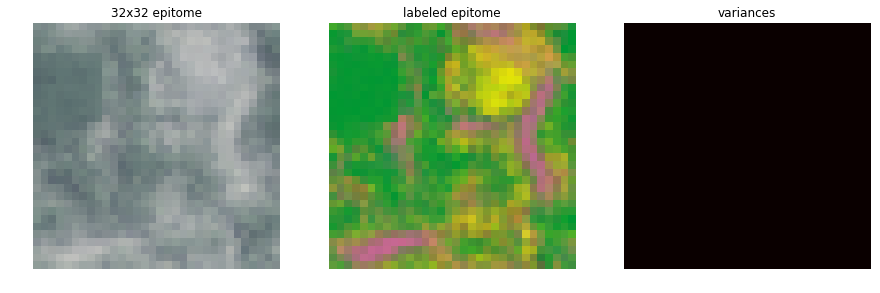

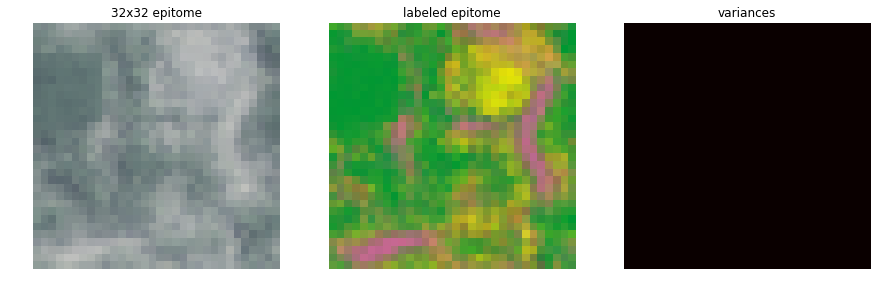

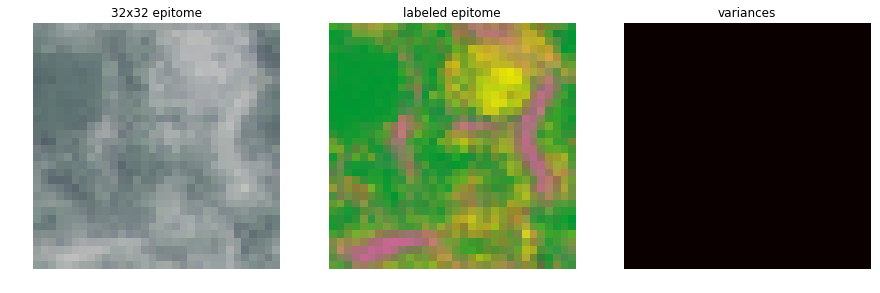

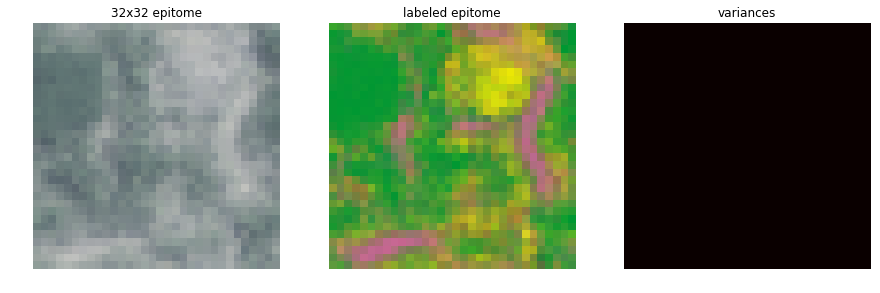

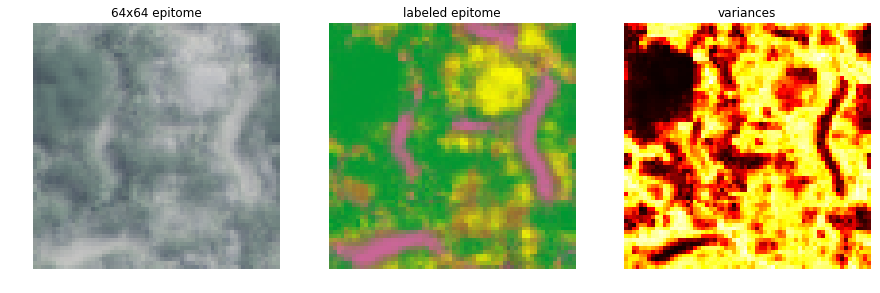

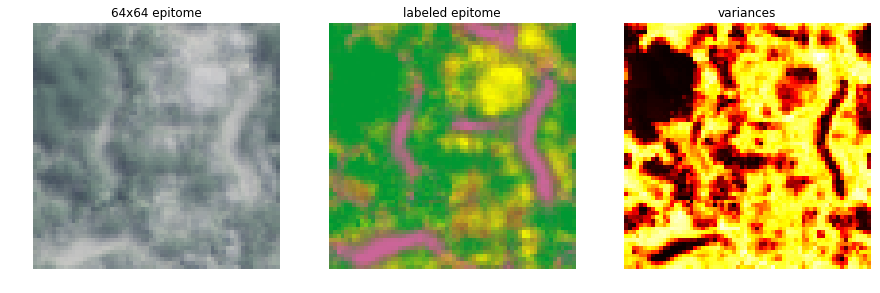

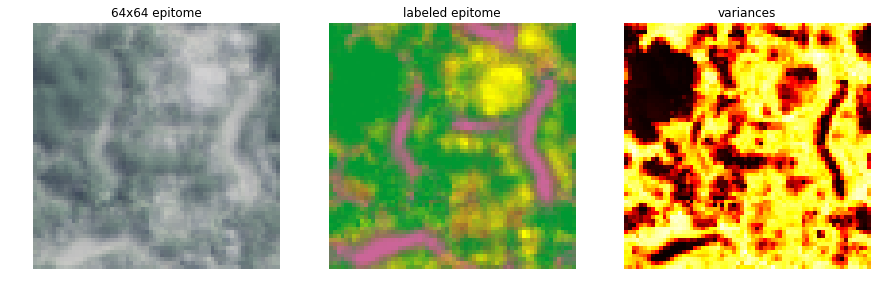

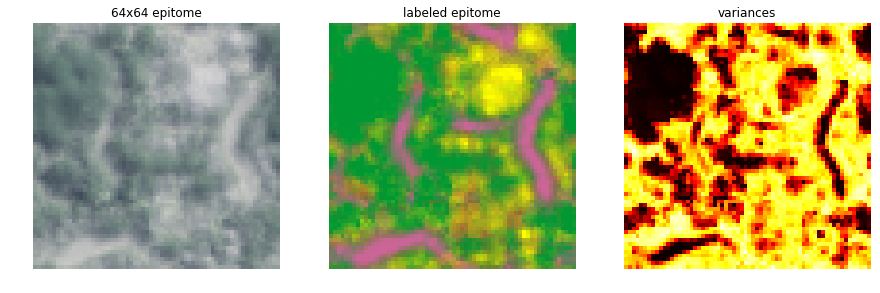

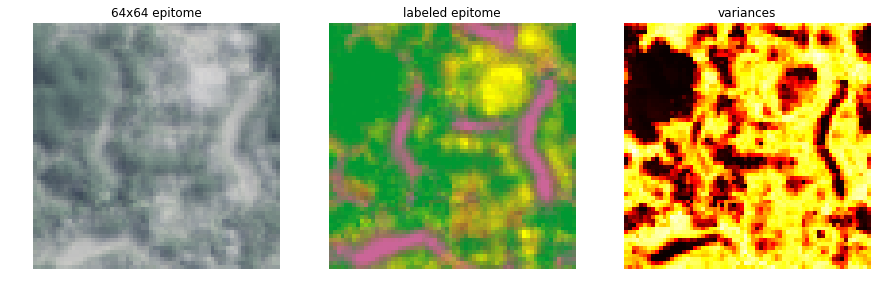

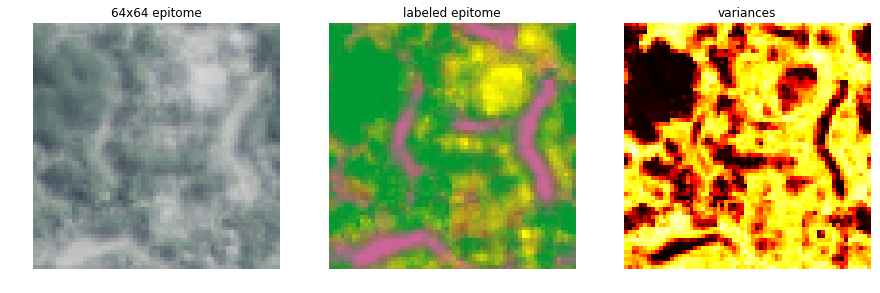

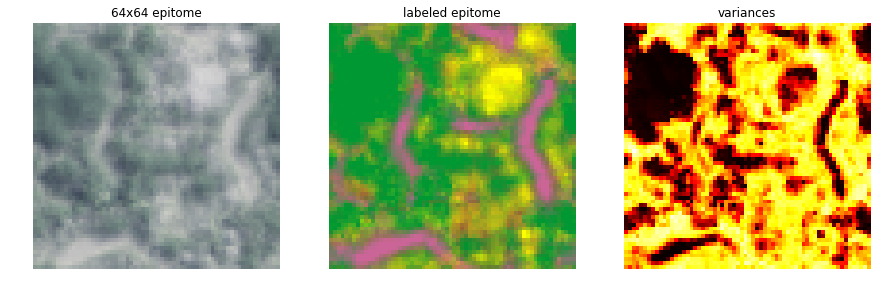

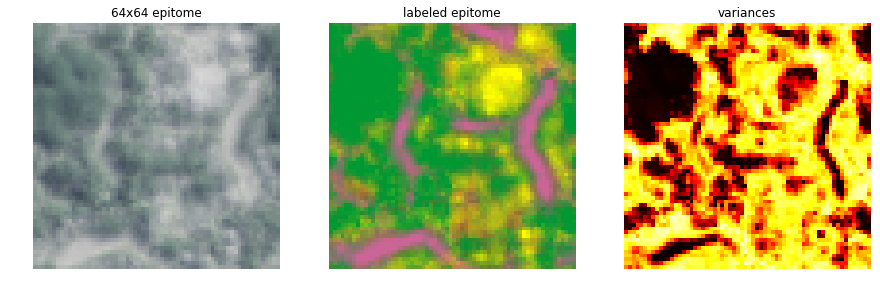

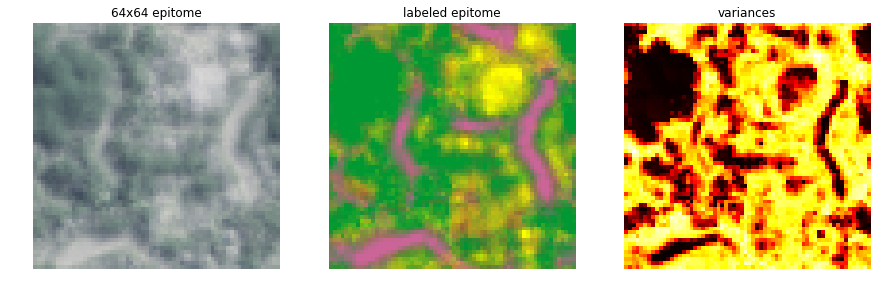

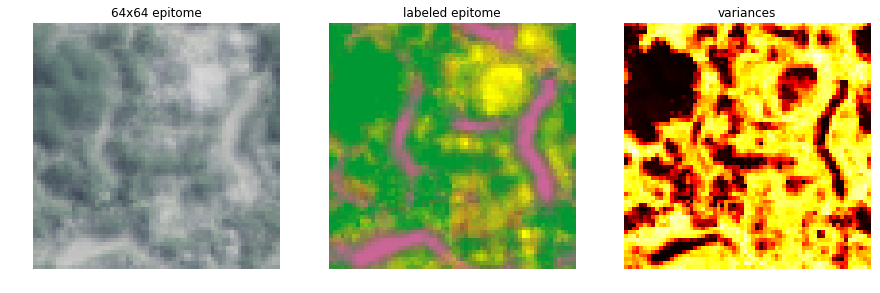

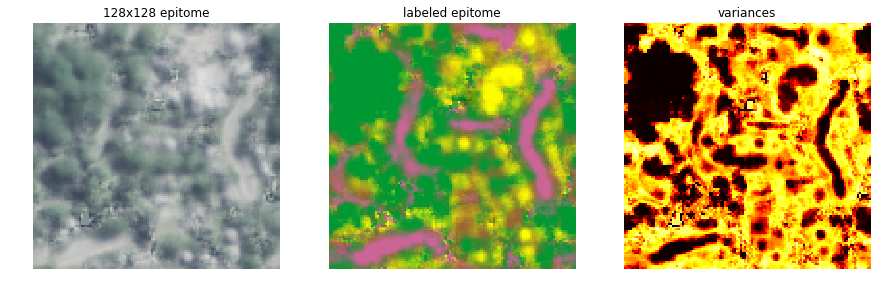

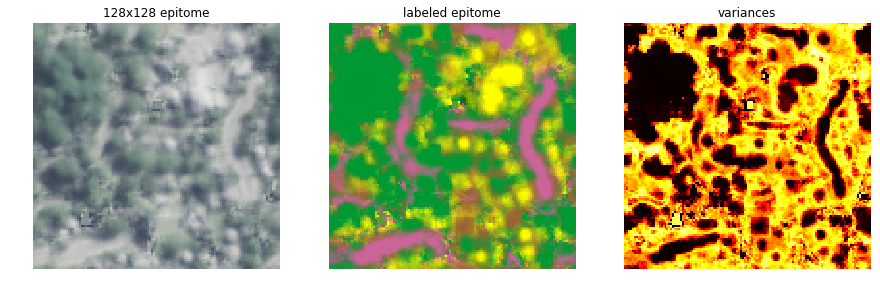

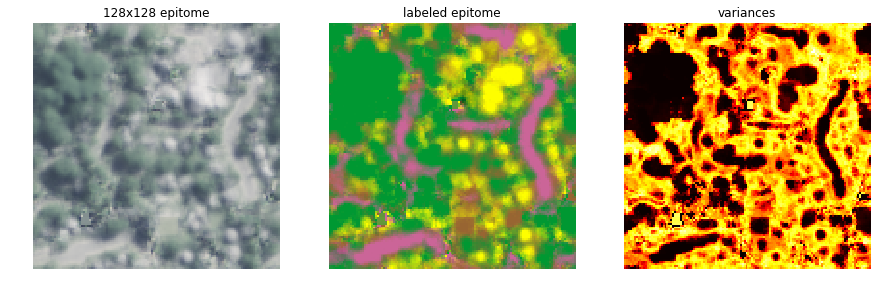

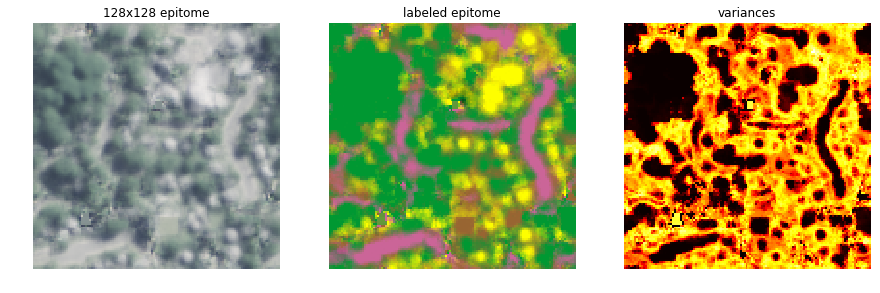

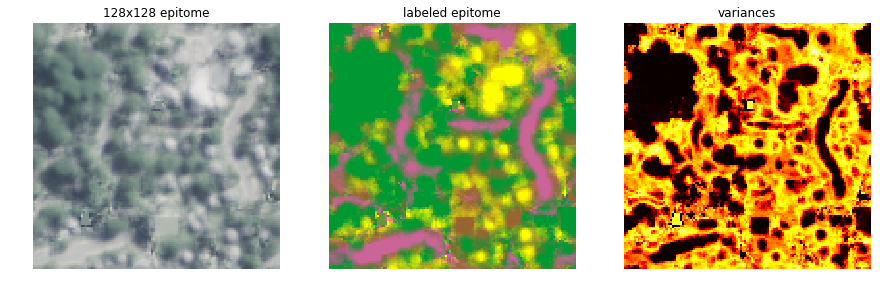

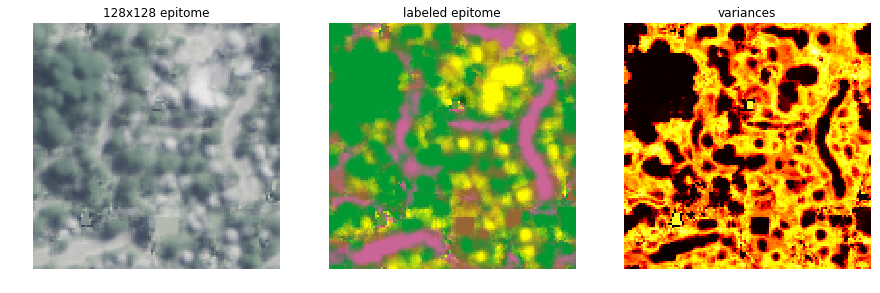

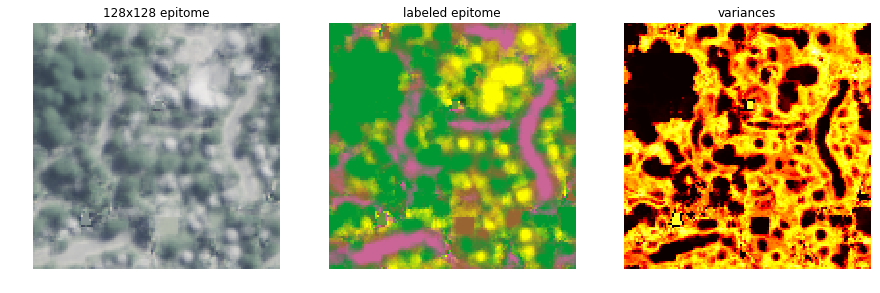

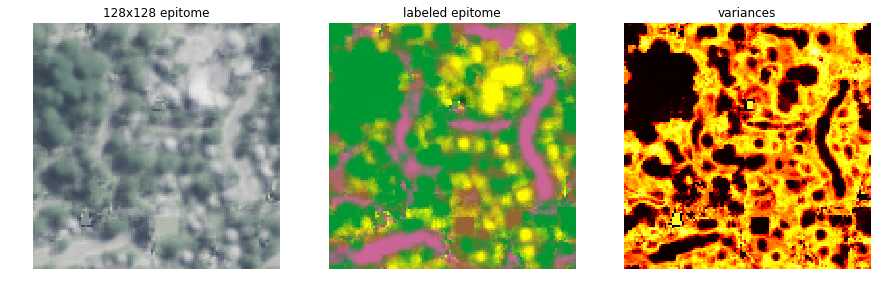

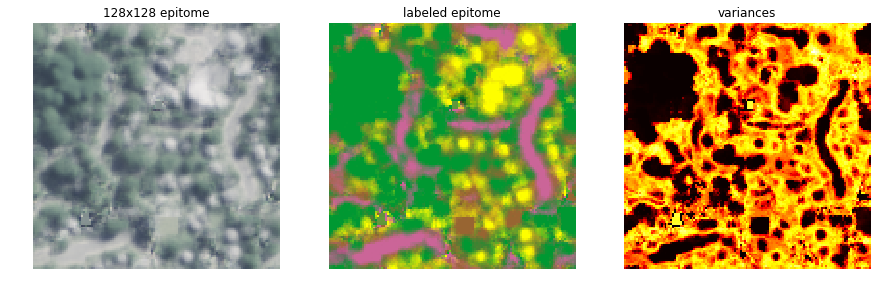

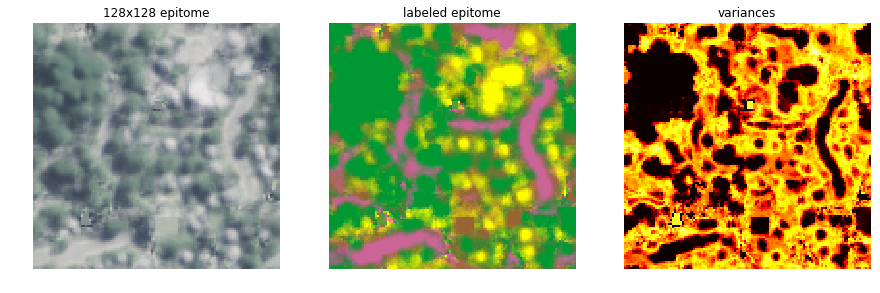

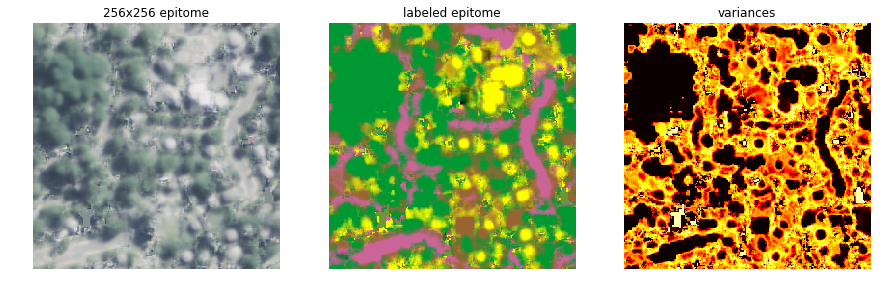

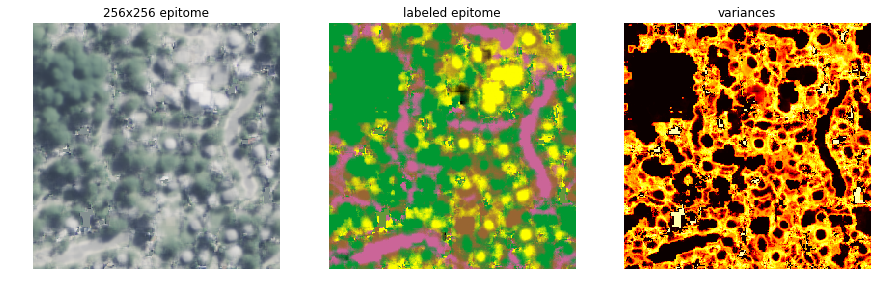

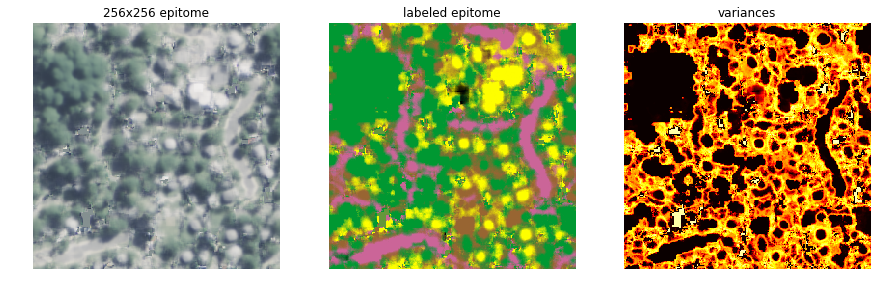

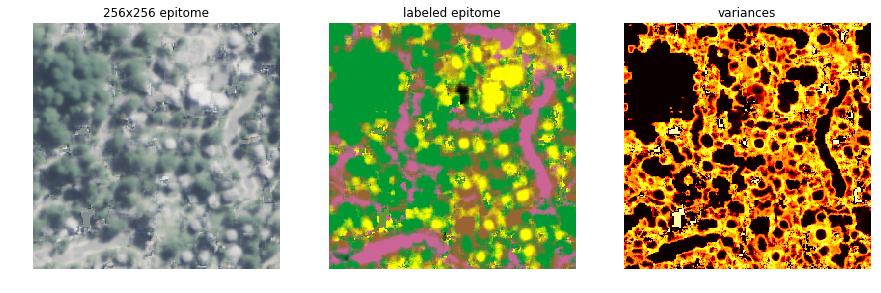

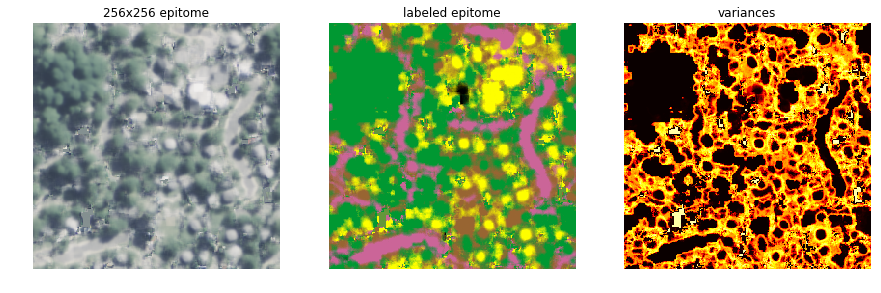

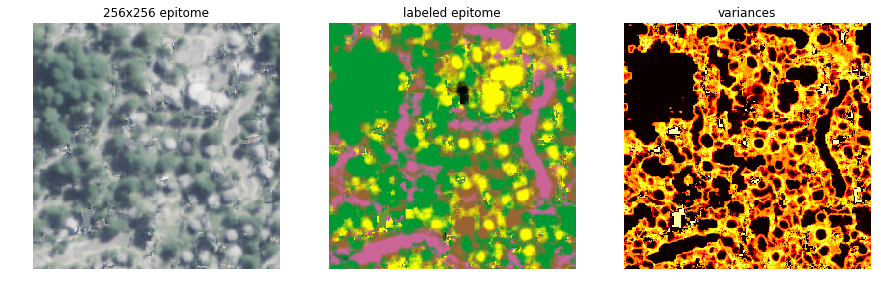

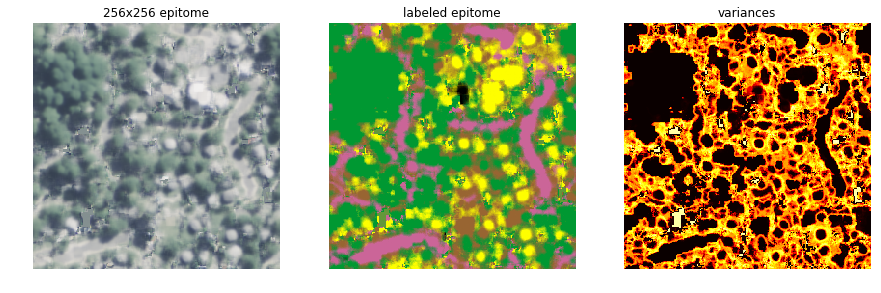

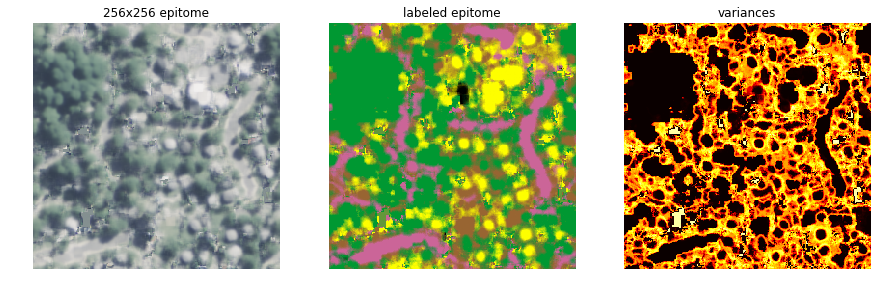

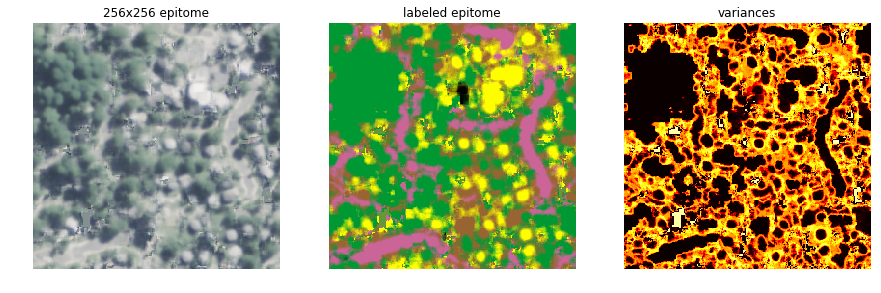

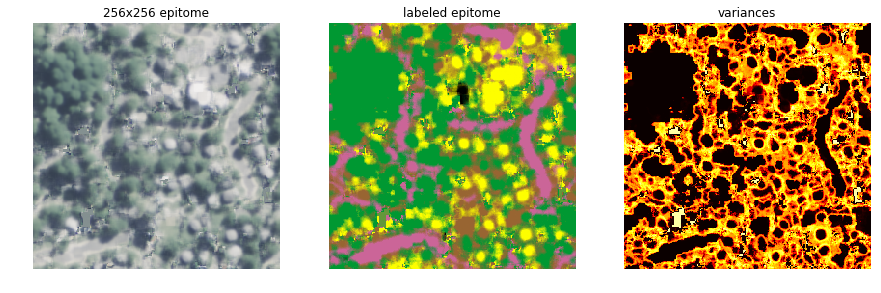

         51149185 function calls (51012905 primitive calls) in 1224.922 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000 1224.922 1224.922 {built-in method builtins.exec}
        1    0.001    0.001 1224.922 1224.922 <string>:1(<module>)
        1  407.556  407.556 1224.921 1224.921 <ipython-input-41-039cc03ce607>:20(epitome)
   664070  351.860    0.001  351.860    0.001 {built-in method max}
   664150   70.774    0.000  157.452    0.000 <ipython-input-41-039cc03ce607>:3(cum_sum)
  1328220    4.575    0.000  142.199    0.000 functional.py:2112(pad)
  1328220   13.171    0.000  136.784    0.000 {built-in method apply}
  1328220   30.984    0.000  123.613    0.000 padding.py:12(forward)
  1328840   96.339    0.000   96.339    0.000 {built-in method conv2d}
   664150   45.775    0.000   45.775    0.000 {built-in method sum}
  3984580   23.110    0.000   23.110    0.000 {method 'narrow' of 'torch._C

      200    0.000    0.000    0.003    0.000 _methods.py:42(_any)
      720    0.001    0.000    0.003    0.000 artist.py:637(set_clip_box)
      120    0.001    0.000    0.003    0.000 _base.py:1662(axis)
      480    0.002    0.000    0.003    0.000 spines.py:318(_calc_offset_transform)
    10560    0.003    0.000    0.003    0.000 font_manager.py:730(get_family)
     6360    0.003    0.000    0.003    0.000 text.py:584(set_wrap)
     1320    0.001    0.000    0.003    0.000 core.py:596(filled)
       40    0.000    0.000    0.003    0.000 session.py:561(msg_header)
      240    0.001    0.000    0.003    0.000 transforms.py:966(intervaly)
      400    0.001    0.000    0.003    0.000 figure.py:462(_get_axes)
      560    0.001    0.000    0.003    0.000 core.py:296(_scalar_fill_value)
      120    0.001    0.000    0.003    0.000 __init__.py:68(process_projection_requirements)
      960    0.003    0.000    0.003    0.000 numeric.py:2592(geterr)
      120    0.000    0.000    0.003

       78    0.000    0.000    0.000    0.000 {method 'release' of '_thread.lock' objects}
        4    0.000    0.000    0.000    0.000 image.py:286(<listcomp>)
       40    0.000    0.000    0.000    0.000 {method 'clear' of 'collections.deque' objects}
       80    0.000    0.000    0.000    0.000 {method '__exit__' of '_thread.lock' objects}
        1    0.000    0.000    0.000    0.000 iostream.py:313(_schedule_flush)
        4    0.000    0.000    0.000    0.000 base.py:1202(isspmatrix)
        1    0.000    0.000    0.000    0.000 linecache.py:15(getline)
        4    0.000    0.000    0.000    0.000 stride_tricks.py:20(__init__)
       40    0.000    0.000    0.000    0.000 formatters.py:824(_check_return)
        1    0.000    0.000    0.000    0.000 iostream.py:300(_is_master_process)
        4    0.000    0.000    0.000    0.000 __init__.py:29(get_config)
        4    0.000    0.000    0.000    0.000 utils.py:5(_ntuple)
        1    0.000    0.000    0.000    0.000 linecache

In [42]:
%%time
#no longer accepts initializations of e or ev
cProfile.run('e,ev,p,etr=epitome(trIMtorch,9,256,50000,10,[.125,.25,.5,1])',sort='cumtime')
#cProfile.run('e,ev,p,etr=epitome(trIMtorch,8,128,4000,20,[.5])',sort='cumtime')
torch.cuda.empty_cache()

In [43]:
#Replaces the epitome (e,ev) of an image by another epitome image emod
#keeping the mapping intact. The routine can be used to edit images or to
#preprocess by coloring the image accoring to the image.
#K is the patch size in mapping inference and SPC is the patch spacing.

def reconstruct(x,K,e,ev,emod,SPC):
    _,NoCh1,SY,SX = x.shape
    NoCh2 = emod.shape[0]
    if NoCh1 == 1:
        x = torch.stack((x,x,x),dim=0)
        print(x.shape)
    N = e.shape[1]
    ewrap = torch.zeros((1,NoCh1,N+K-1,N+K-1)).to(device)
    evwrap = torch.zeros((1,NoCh1,N+K-1,N+K-1)).to(device)
    ewrap[0,:,:N,:N] = e
    ewrap[:,:,N:,:] = ewrap[:,:,:K-1,:]
    ewrap[:,:,:,N:] = ewrap[:,:,:,:K-1]
    evwrap[0,:,:N,:N] = ev
    evwrap[:,:,N:,:] = evwrap[:,:,:K-1,:]
    evwrap[:,:,:,N:] = evwrap[:,:,:,:K-1]
    evwrapi = 1./evwrap
    tmp3 = torch.sum(torch.squeeze(cum_sum(ewrap**2*evwrapi,K)),dim=0)
    tmp4 = torch.sum(torch.squeeze(cum_sum(torch.log(evwrap),K)),dim=0)
    emodwrap = torch.zeros((NoCh2,N+K-1,N+K-1)).to(device)
    emodwrap[:,:N,:N] = emod
    emodwrap[:,N:,:] = emodwrap[:,:K-1,:]
    emodwrap[:,:,N:] = emodwrap[:,:,:K-1]
    z = torch.zeros((NoCh2,SY,SX)).to(device)
    cnt = torch.zeros((SY,SX)).to(device)
    ixt = 0
    iyt = 0
    #MINP = 1e-8
    #for each patch of the input, find the distribution over the epitome positions,
    #and reconstruct the patch in the input image, using the modified epitome.
    for iy in range(0,SY-K+1,SPC):
        print('y index = '+str(iy))
        for ix in range(0,SX-K+1,SPC):
            #watch for indexing errors
            yct = torch.flip(x[:,:,iy:iy+K,ix:ix+K],[2,3])
            #print(yct.shape)
            tmp1 = torch.squeeze(F.conv2d(evwrapi,yct**2))
            tmp2 = torch.squeeze(F.conv2d(ewrap*evwrap,yct))
            #print(tmp1.shape,tmp2.shape,tmp3.shape,tmp4.shape)
            lP = -.5*(tmp4+tmp1-2*tmp2+tmp3)
            #P = torch.exp(lP-torch.max(lP))#+MINP
            #P /= torch.sum(P)
            #argmax = torch.argmax(P)
            argmax = torch.argmax(lP)
            mxpi = argmax//lP.shape[0]
            mxpj = argmax - mxpi*lP.shape[0]
            #watch for indexing errors
            z[:,iy:iy+K,ix:ix+K] += emodwrap[:,mxpi:mxpi+K,mxpj:mxpj+K]#did not switch i and j
            cnt[iy:iy+K,ix:ix+K] += 1
            ixt = ix
        iyt = iy
    print(ixt,iyt)
    z = z[:,:iyt+K,:ixt+K]
    cnt = cnt[:iyt+K,:ixt+K]
    z /= cnt
    return z.cpu().numpy()

In [37]:
%%time
cProfile.run('z=reconstruct(tsIMtorch[:,:4,:,:],17,e[0,:4,:,:],ev[0,:4,:,:],e[0,4:,:,:],3)',sort='cumtime')
torch.cuda.empty_cache()

y index = 0
y index = 3
y index = 6
y index = 9
y index = 12
y index = 15
y index = 18
y index = 21
y index = 24
y index = 27
y index = 30
y index = 33
y index = 36
y index = 39
y index = 42
y index = 45
y index = 48
y index = 51
y index = 54
y index = 57
y index = 60
y index = 63
y index = 66
y index = 69
y index = 72
y index = 75
y index = 78
y index = 81
y index = 84
y index = 87
y index = 90
y index = 93
y index = 96
y index = 99
y index = 102
y index = 105
y index = 108
y index = 111
y index = 114
y index = 117
y index = 120
y index = 123
y index = 126
y index = 129
y index = 132
y index = 135
y index = 138
y index = 141
y index = 144
y index = 147
y index = 150
y index = 153
y index = 156
y index = 159
y index = 162
y index = 165
y index = 168
y index = 171
y index = 174
y index = 177
y index = 180
y index = 183
y index = 186
y index = 189
y index = 192
y index = 195
y index = 198
y index = 201
y index = 204
y index = 207
y index = 210
y index = 213
y index = 216
y index = 219
y 

In [31]:
#np.savez_compressed('reconstruction2',a=zcpu)
print(z.shape)
z2 = np.rollaxis(z,0,3)
labels = np.matmul(z2,palette[1:])/256
print(labels.shape)

(6, 1022, 1022)
(1022, 1022, 3)


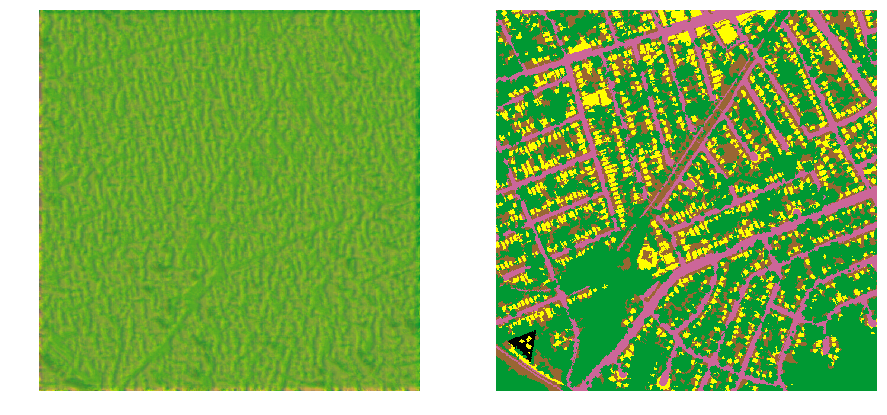

In [32]:
fig=plt.figure(figsize=(15,10))
fig.add_subplot(121)
plt.axis('off')
plt.imshow(labels)
fig.add_subplot(122)
plt.axis('off')
plt.imshow(palette[lc])
plt.show()
plt.close()

In [25]:
labtest = np.zeros(z2.shape)
for i in range(6):
    labtest += i*z2[i,:,:]
labtest /= np.sum(z2,axis=0)
labtest

array([[[1.65948926e+00, 1.62792420e+00, 1.13037124e+00, ...,
         2.39139301e-04, 8.89600111e-02, 4.09942357e-02],
        [1.72000104e+00, 1.52139059e+00, 1.38769103e+00, ...,
         2.06746652e-01, 1.17686771e-01, 5.28596713e-02],
        [1.53916431e+00, 1.40352504e+00, 1.38803196e+00, ...,
         5.89581994e-01, 1.37933143e-01, 4.70786954e-01],
        ...,
        [3.91257860e+00, 4.70501626e+00, 4.57043274e+00, ...,
         3.54977567e+00, 2.99988270e+00, 2.29637729e+00],
        [3.69522563e+00, 4.99910571e+00, 4.19919631e+00, ...,
         3.13495768e+00, 2.69555214e+00, 1.94442518e+00],
        [2.99969265e+00, 3.99907819e+00, 4.18072687e+00, ...,
         2.68391264e+00, 2.31105462e+00, 2.01884066e+00]],

       [[1.65948926e+00, 1.62792420e+00, 1.13037124e+00, ...,
         2.39139301e-04, 8.89600111e-02, 4.09942357e-02],
        [1.72000104e+00, 1.52139059e+00, 1.38769103e+00, ...,
         2.06746652e-01, 1.17686771e-01, 5.28596713e-02],
        [1.53916431e+00, 

In [33]:
e_colors = e[0,4:,:,:].permute(1,2,0).view(-1,6)
palette_torch = torch.from_numpy(palette[1:,:]).float().to(device)

In [34]:
labeled = np.reshape(torch.mm(e_colors,palette_torch).cpu().numpy()/256,(256,256,3))

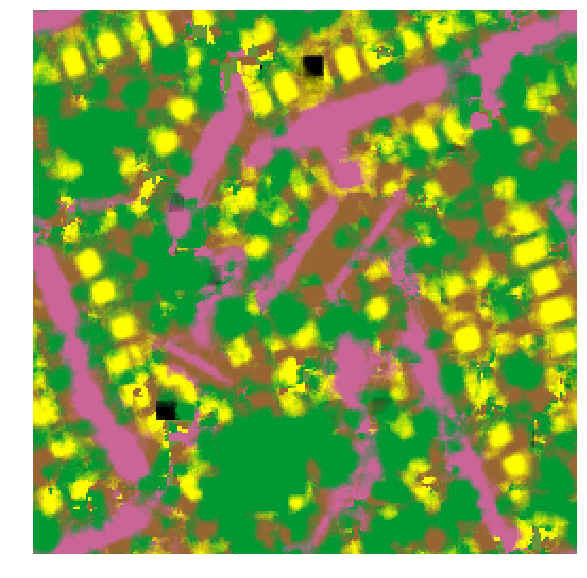

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(labeled)
plt.axis('off')
plt.show()
plt.close()